C:\Users\bhaut\AppData\Local\Temp\ipykernel_14012\3367935434.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


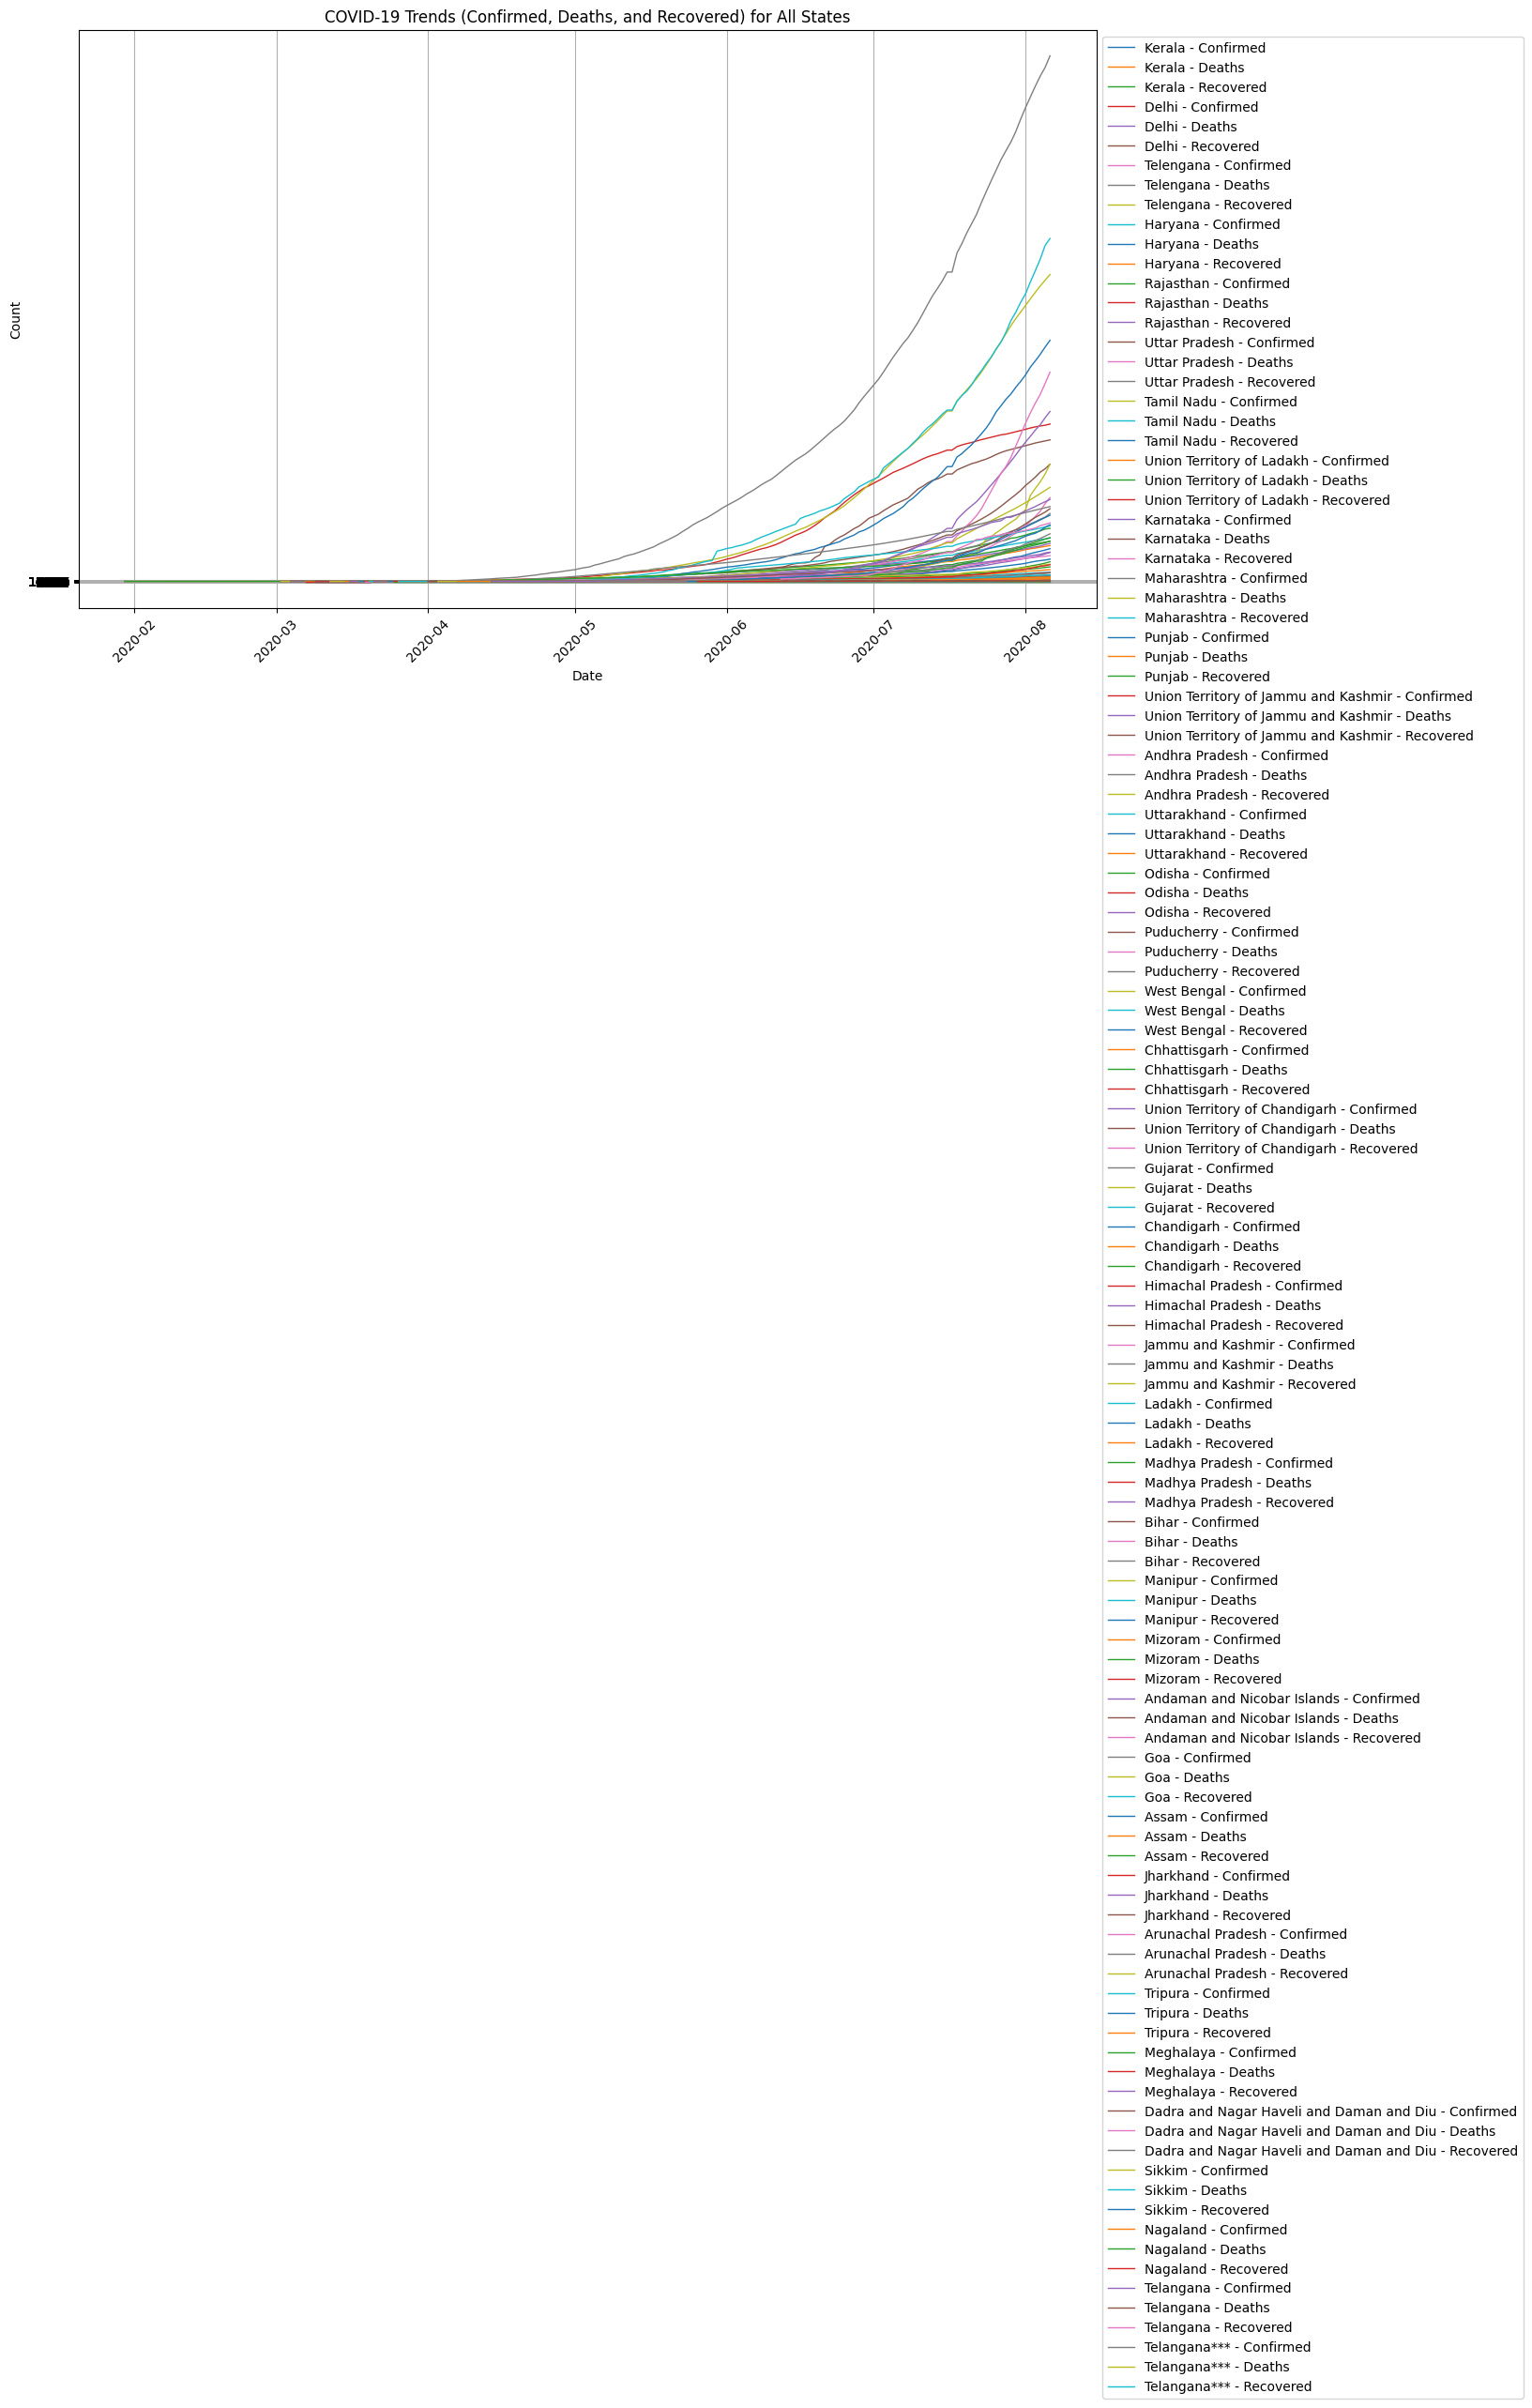

TypeError: unsupported operand type(s) for +: 'float' and 'str'

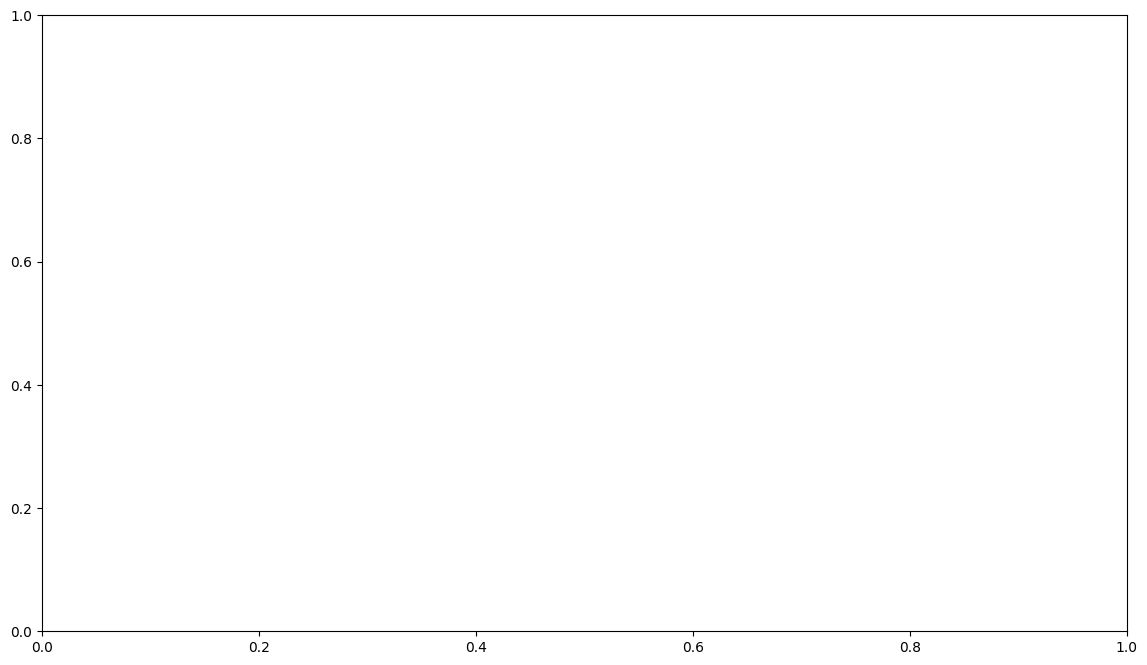

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace 'complete.csv' with the actual path to your CSV file)
df = pd.read_csv('complete.csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Drop rows with missing data (optional, based on dataset quality)
df = df.dropna()

# 1. Plot Time Series for Total Confirmed cases, Deaths, and Recovered for All States
plt.figure(figsize=(14, 8))
for state in df['Name of State / UT'].unique():
    df_state = df[df['Name of State / UT'] == state]
    plt.plot(df_state['Date'], df_state['Total Confirmed cases'], label=f'{state} - Confirmed', linewidth=1)
    plt.plot(df_state['Date'], df_state['Death'], label=f'{state} - Deaths', linewidth=1)
    plt.plot(df_state['Date'], df_state['Cured/Discharged/Migrated'], label=f'{state} - Recovered', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('COVID-19 Trends (Confirmed, Deaths, and Recovered) for All States')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Stacked Area Plot for All States (Confirmeds, Deaths, and Recovered)
plt.figure(figsize=(14, 8))
for state in df['Name of State / UT'].unique():
    df_state = df[df['Name of State / UT'] == state]
    plt.stackplot(df_state['Date'], 
                  df_state['Total Confirmed cases'], 
                  df_state['Death'], 
                  df_state['Cured/Discharged/Migrated'], 
                  labels=['Confirmed', 'Deaths', 'Recovered'],
                  alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('COVID-19 Stacked Area Plot for All States')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Scatter Plot: Confirmed cases vs Deaths for All States
plt.figure(figsize=(8, 6))
for state in df['Name of State / UT'].unique():
    df_state = df[df['Name of State / UT'] == state]
    plt.scatter(df_state['Total Confirmed cases'], df_state['Death'], alpha=0.6, label=state)

plt.xlabel('Total Confirmed Cases')
plt.ylabel('Deaths')
plt.title('Scatter Plot: Confirmed Cases vs Deaths for All States')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Pairplot for the selected columns for All States
columns_to_plot = ['Total Confirmed cases', 'Death', 'Cured/Discharged/Migrated', 'New cases', 'New deaths']
sns.pairplot(df[columns_to_plot], hue='Name of State / UT', diag_kind='kde')
plt.suptitle('Pairwise Relationships of COVID-19 Data for All States', y=1.02)
plt.show()

# 5. Correlation Heatmap for All States
corr_matrix = df[columns_to_plot].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of COVID-19 Data for All States')
plt.show()

# 6. Rolling Average for Confirmed cases, Deaths, and Recovered for All States
df['Confirmed Rolling Avg'] = df['Total Confirmed cases'].rolling(window=7).mean()
df['Death Rolling Avg'] = df['Death'].rolling(window=7).mean()
df['Recovered Rolling Avg'] = df['Cured/Discharged/Migrated'].rolling(window=7).mean()

plt.figure(figsize=(14, 8))
for state in df['Name of State / UT'].unique():
    df_state = df[df['Name of State / UT'] == state]
    plt.plot(df_state['Date'], df_state['Confirmed Rolling Avg'], label=f'{state} - Confirmed (7-day avg)', linewidth=2)
    plt.plot(df_state['Date'], df_state['Death Rolling Avg'], label=f'{state} - Deaths (7-day avg)', linewidth=2)
    plt.plot(df_state['Date'], df_state['Recovered Rolling Avg'], label=f'{state} - Recovered (7-day avg)', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('7-Day Rolling Average for COVID-19 Data for All States')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
